# Assignment 2 PCA Report

### name: Ruiling Chen, student number: 45737455

* The goal of the assignment is to implement a nearest-neighbour face recognition algorithm based on Eigenfaces as discussed in Lecture 4 – PCA & LDA. We will be using a database consisting of 10 images each of 40 different people. The image resolution is 32x32, corresponding to the extrinsic dimension of 1024. The task is to correctly identify the person from a test image using a low-dimensional eigenface representation.
  
  
* The datasets are faces_train.txt and faces_train.txt. Each row in these files contain 32x32 = 1024 pixel values. We will be using 7 images per person for training and 3 images for testing. The first 7 images in the training data and the first 3 images in the test data is of person A and so on. The labels for the two datasets are given in faces_train_labels.txt and faces_test_labels.txt.


In [1]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt

train_datafile = "faces_train.txt"
train_labelfile = "faces_train_labels.txt"
test_datafile = "faces_test.txt"
test_labelfile = "faces_test_labels.txt"

train_data = np.genfromtxt(train_datafile, dtype= 'float')
train_label = np.genfromtxt(train_labelfile, dtype= 'int')
test_data = np.genfromtxt(test_datafile, dtype= 'float')
test_label = np.genfromtxt(test_labelfile, dtype= 'int')

meanface = train_data.mean(axis = 0)
train_centered = train_data - meanface
CovMatrix = np.dot(train_centered.T, train_centered)
_, eig_vectors = np.linalg.eigh(CovMatrix)

eig_vectors = eig_vectors.T # the output eigen vectors from np.linalg.eigh() are stored as columns
sort_eigvecs = eig_vectors[::-1]

# 1. The pictures of the mean face and top 5 eigenfaces computed by PCA

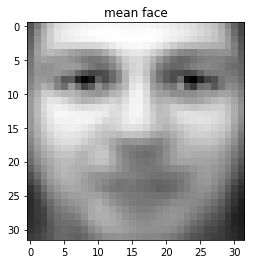

In [2]:
# show the mean face
plt.title('mean face')
plt.imshow(meanface.reshape((32, 32), order = 'F'), cmap=plt.cm.gray)

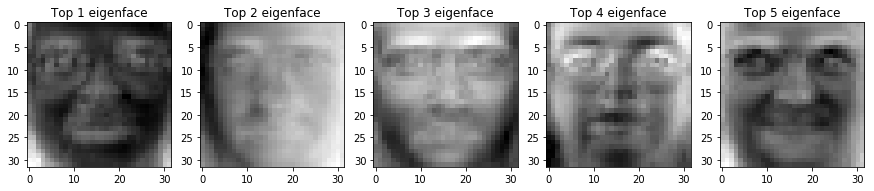

In [3]:
# show the top 5 eigenfaces
K = 5
eigenfaces = sort_eigvecs[0:K]

plt.figure(figsize=(15, 3))
for k in range(K):
    plt.subplot(1, 5, k+1)
    plt.title('Top ' + str(k+1) + ' eigenface')
    plt.imshow(eigenfaces[k].reshape((32, 32), order = 'F'), cmap=plt.cm.gray)

# 2. Project and reconstruct one face image

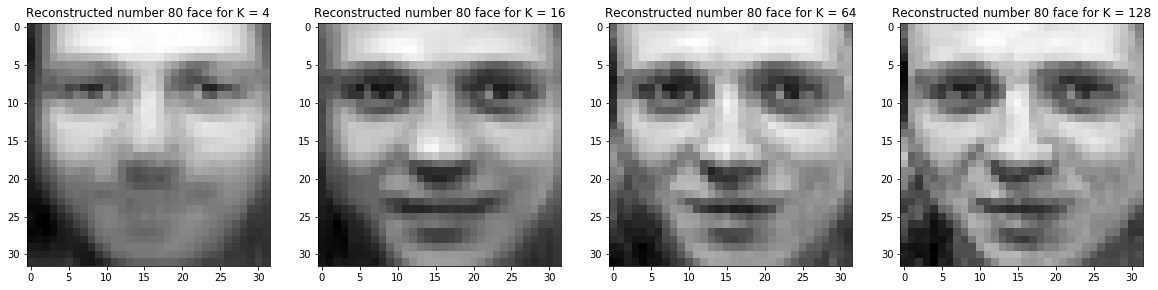

In [4]:
# choose number 80 face (number 79 in python)
img_position = 1
plt.figure(figsize=(20, 5))
for K in [4, 16, 64, 128]:
    eigenfaces = sort_eigvecs[0:K]

    face_projection = np.transpose(np.dot(eigenfaces, train_centered[79].T))
    face_weight = np.dot(train_centered[79], eigenfaces.T)
    reconstruct_face = meanface + np.dot(face_weight, eigenfaces)
    
    plt.subplot(1, 4, img_position)
    plt.title('Reconstructed number 80 face for K = ' + str(K))
    plt.imshow(reconstruct_face.reshape((32, 32), order = 'F'), cmap=plt.cm.gray)
    img_position += 1

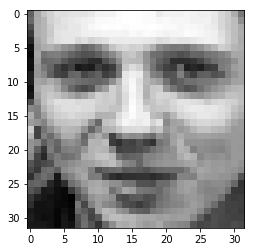

In [5]:
# the original picture
plt.imshow(train_data[79].reshape((32, 32), order = 'F'), cmap=plt.cm.gray)

For K equals to 4, the reconstructed face looks almost the same as the mean face, with a little bit clearer facial contours. For K equals to 16, the facial features are more distinct but still not clear enough. The reconstructed face or K equals to 64 is way more better, and we can nearly make a conclusion of who he is. And for K equals to 128, we can see that it is almost the same as the original face, which means that 128 components (or even fewer) are enough for reconstruction.

# 3. The plot of the 1NN classification rate

In [6]:
Ks = [] # a list of K values (from 1 to 300)
accus = [] # a list of accuracy rate

for K in range(300):
    K += 1 # loop for K from 1 to 300
    eigenfaces = sort_eigvecs[0:K]
    train_projection = np.transpose(np.dot(eigenfaces, train_centered.T)) # training set projection

    # project test set into face space
    test_centered = test_data - meanface
    test_projection = np.transpose(np.dot(eigenfaces, test_centered.T))

    my_label = np.zeros(test_label.shape, dtype = 'int') # store the identified result with 1NN
    
    for faceIndex in range(len(test_label)):
        # calculate the Euclidean distance between the test face and every training face in the face space.
        dists = [np.linalg.norm(train_projection[trainIndex] - test_projection[faceIndex]) 
                 for trainIndex in range(len(train_label))]
        
        min_index = np.where(dists == min(dists))
        # get the index of the minimum distance (with integer type):
        min_index = int(min_index[0])
        
        my_label[faceIndex] = train_label[min_index]
        
    accu = sum(my_label == test_label) / len(test_label)
    
    Ks.append(K)
    accus.append(accu)


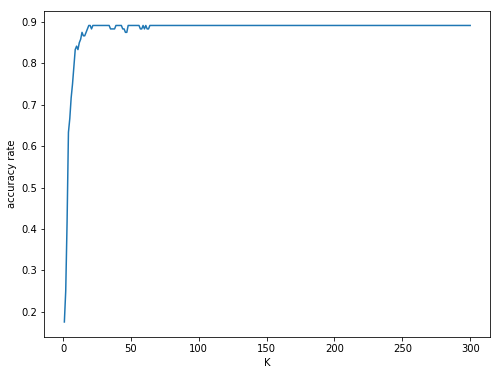

In [7]:
# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(Ks, accus)
ax.set_xlabel('K')
ax.set_ylabel('accuracy rate')

plt.show()

The plot above shows that, when K is between 1 and 10, the accuracy rate increase rapidly from less than 0.2 to around 0.8. After a slightly shock until K > 20, the accuracy rate becomes stable at about 0.89.

# 4. Incorrectly classified faces

In [8]:
K = 100
eigenfaces = sort_eigvecs[0:K]

train_projection = np.transpose(np.dot(eigenfaces, train_centered.T)) # training set projection

# project to face space
test_centered = test_data - meanface
test_projection = np.transpose(np.dot(eigenfaces, test_centered.T))

my_label = np.zeros(test_label.shape, dtype = 'int')
theface_index = [] # the index of faces that are incorrectly classified
nearest_index = [] # their nearest neighbours from the training set

for faceIndex in range(len(test_label)):
    dists = [np.linalg.norm(train_projection[distIndex] - test_projection[faceIndex]) 
             for distIndex in range(len(dists))]
    min_index = np.where(dists == min(dists))
    # type:
    min_index = int(min_index[0])
    if train_label[min_index] != test_label[faceIndex]:
        theface_index.append(faceIndex)
        nearest_index.append(min_index)


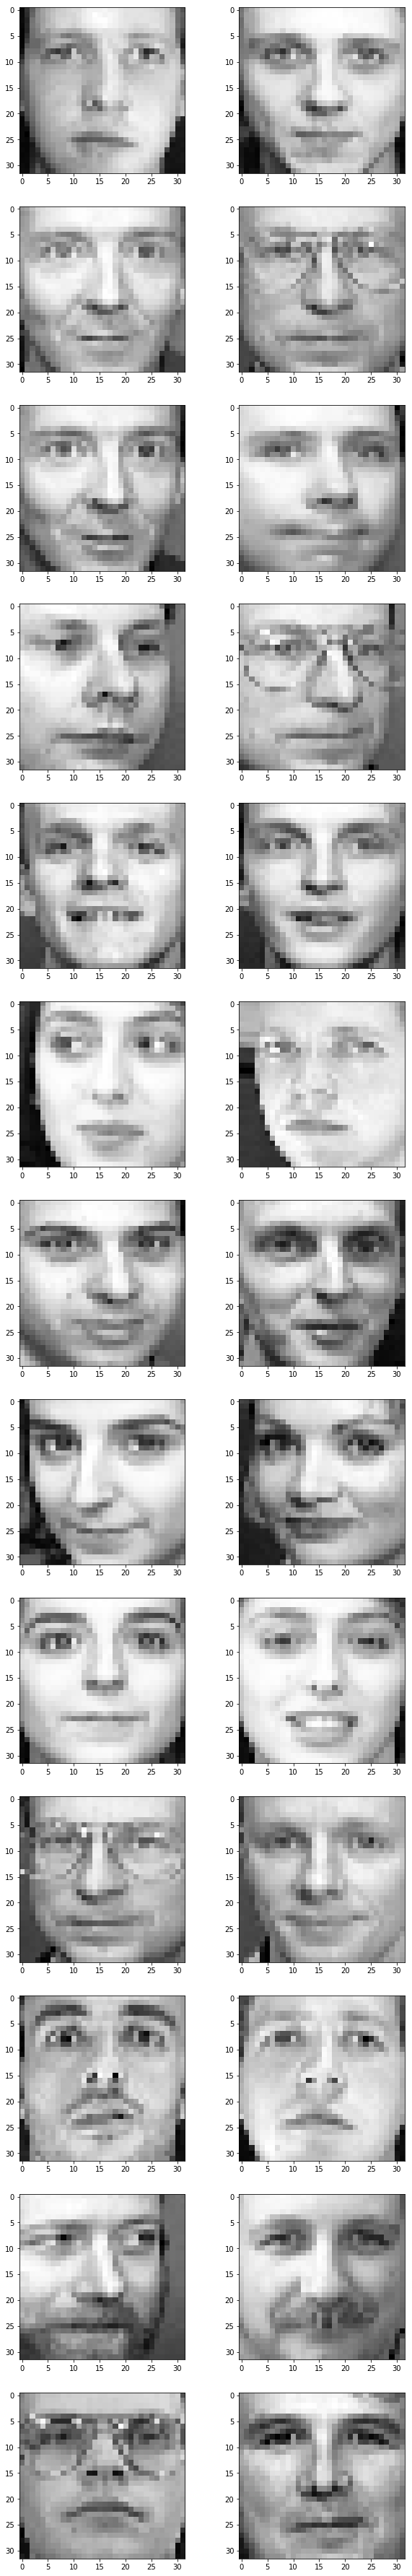

In [9]:

plt.figure(figsize=(10, 5*len(theface_index)))

for index in range(len(theface_index)):
    face_position = index + index + 1
    
    plt.subplot(len(theface_index), 2, face_position)
    plt.imshow(test_data[theface_index[index]].reshape((32, 32), order = 'F'), cmap=plt.cm.gray)
    
    plt.subplot(len(theface_index), 2, face_position + 1)
    plt.imshow(train_data[nearest_index[index]].reshape((32, 32), order = 'F'), cmap=plt.cm.gray)
    

By comparing the incorrectly classified faces and their nearest neighbours, we can conclude that the mainly reason why they are misclassified is their eyes, noses and mouths are almost at the same position, which makes them looks similar.

# Extra credits

* Extract a few 32x32 patches from non-face images and investigate their behavior when they are projected onto the “face space”. Project these patches onto the face space for different values of K, and display the reconstructed versions of these patches, along with the reconstruction errors.

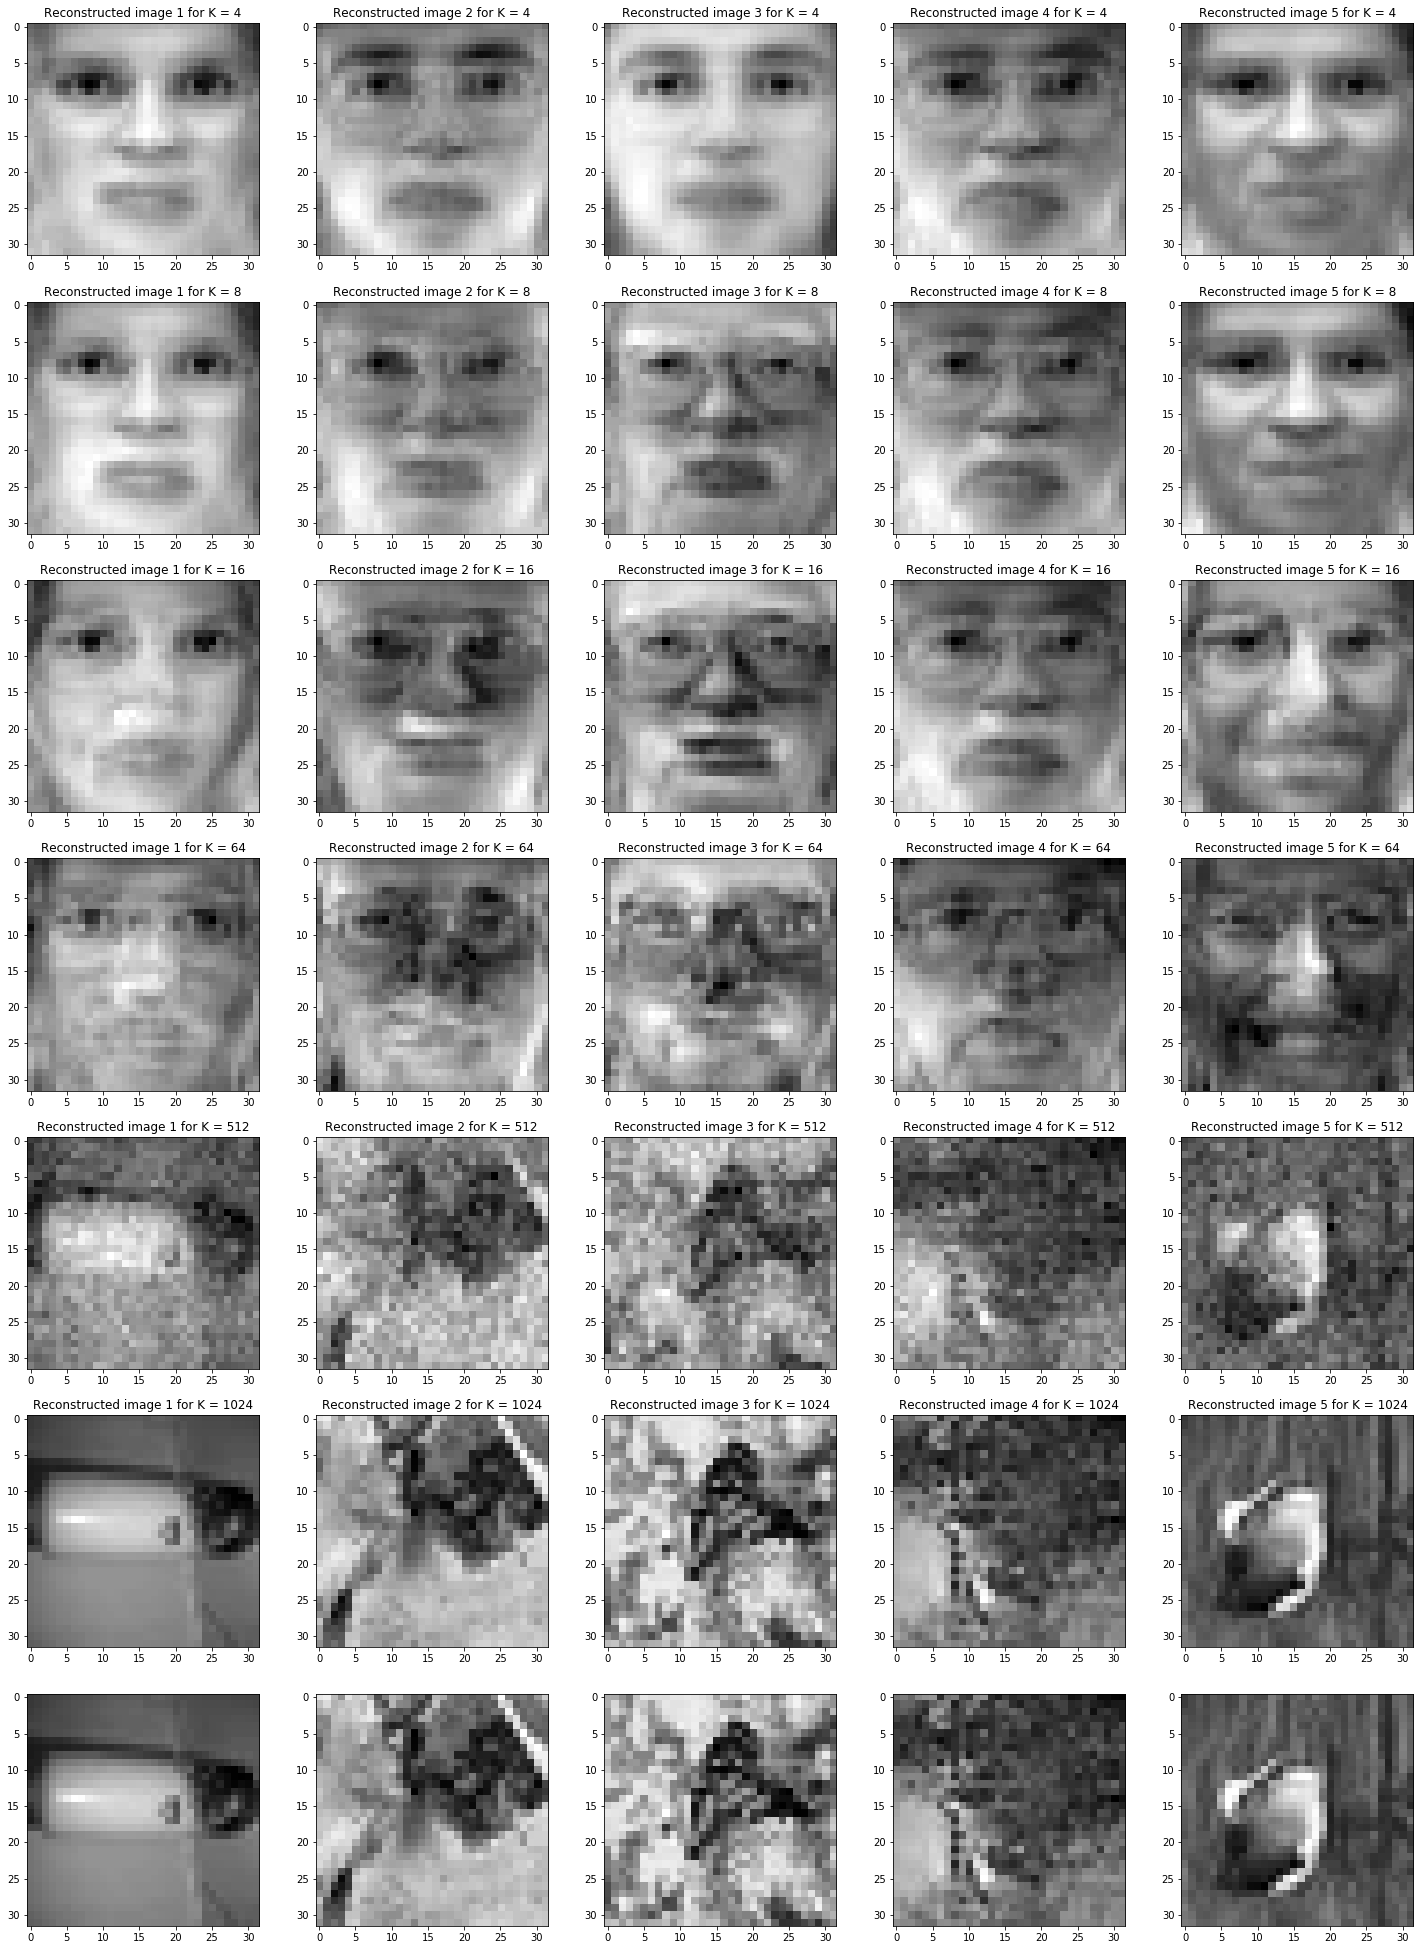

In [14]:
import matplotlib.image as mpimg
from PIL import Image

# load non-face images
nonface_data = np.empty([5, 1024], dtype = int) 
for img_number in range(5):
    img_name = "extra_img/test_" + str(img_number) + ".JPEG"
    nonface_img = Image.open(img_name)
    nonface_img_resize = nonface_img.resize((32, 32), Image.ANTIALIAS)
    nonface_img_gray = nonface_img_resize.convert('L')
    nonface_array = np.array(nonface_img_gray).reshape((1, 1024))#, dtype = np.uint8)
    nonface_data[img_number] = nonface_array

re_errors = np.zeros((6, 5))
plt.figure(figsize=(25, 35))
K_Index = 0
for K in [4, 8, 16, 64, 512, 1024]:
    eigenfaces = sort_eigvecs[0:K]
    train_projection = np.transpose(np.dot(eigenfaces, train_centered.T)) # training set projection

    # project test set into face space
    nonface_centered = nonface_data - meanface
    nonface_projection = np.transpose(np.dot(eigenfaces, nonface_centered.T))

    # reconstruct
    weights = np.dot(nonface_centered, eigenfaces.T)
    recon_nonfaces = meanface + np.dot(weights, eigenfaces)
    recon_nonfaces_normalized = (recon_nonfaces - recon_nonfaces.min()) / (recon_nonfaces.max() 
                                                                           - recon_nonfaces.min()) * 225
    for imgIndex in range(5):
        face_position = imgIndex + K_Index * 5 + 1        
        plt.subplot(7, 5, face_position)
        plt.title('Reconstructed image '+str(imgIndex + 1)+' for K = '+str(K))
        plt.imshow(recon_nonfaces_normalized[imgIndex].reshape((32, 32), order = 'F'), cmap = plt.cm.gray)
        re_errors[K_Index, imgIndex] = np.linalg.norm(recon_nonfaces_normalized[imgIndex] - nonface_data[imgIndex])
    K_Index += 1
    
for imgIndex in range(5):
    plt.subplot(7, 5, 31 + imgIndex)
    plt.imshow(nonface_data[imgIndex].reshape((32, 32), order = 'F'), cmap = plt.cm.gray)

When K = 4 and 8, the reconstructed images look like faces but unclear. When K = 64 and 512, the images look like a mess, they are not like faces or items. For K = 1024, the images are the same as the original images, which means that the construct results are good in this case.

# reconstruction errors

In [11]:
re_errors

array([[ 983.59658176, 1757.46351077, 1935.72907575, 1023.14180193,
        1333.14825975],
       [ 973.83588884, 1652.17984487, 1728.14697872, 1030.97985392,
        1372.79115116],
       [1086.5744502 , 1624.17766146, 1772.43438442, 1175.376559  ,
        1428.40194345],
       [ 984.17184344, 1492.9144608 , 1578.62284952, 1091.58904546,
        1233.95044497],
       [ 749.76549461, 1109.24155867, 1190.90920901,  727.65422543,
         803.08863022],
       [ 516.00851012,  580.88255153,  606.55293228,  452.38524706,
         428.92878818]])